In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from collections import defaultdict

import numpy as np
from numpy import linalg as la

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull

from plyfile import PlyData, PlyElement

from pprint import pprint

In [3]:
np.set_printoptions(precision=8, linewidth=100)

In [4]:
class Lattice(object):
    def __init__(self, X, Y, Z, A, B):
        # sets of possible values for each coordinate
        self.X, self.Y, self.Z, self.A, self.B = X, Y, Z, A, B

        # cardinalities
        self.card_X, self.card_Y, self.card_Z, self.card_A, self.card_B = len(X), len(Y), len(Z), len(A), len(B)

    def ixyzab_to_i(self, ix, iy, iz, ia, ib):
        return ib + \
            ia * self.card_B + \
            iz * self.card_B * self.card_A + \
            iy * self.card_B * self.card_A * self.card_Z + \
            ix * self.card_B * self.card_A * self.card_Z * self.card_Y

    def xyzab_to_i(self, x, y, z, a, b):
        ix = self.X.index(x)
        iy = self.Y.index(y)
        iz = self.Z.index(z)
        ia = self.A.index(a)
        ib = self.B.index(b)
        return self.ixyzab_to_i(ix, iy, iz, ia, ib)
        
    def i_to_xyzab(self, i):
        DM = self.card_B * self.card_A * self.card_Z * self.card_Y
        M = self.card_B * self.card_A * self.card_Z
        C = self.card_B * self.card_A
        D = self.card_B
        
        ix = int(i / DM)
        iy = int((i % DM) / M)
        iz = int(((i % DM) % M) / C)
        ia = int((((i % DM) % M) % C) / D)
        ib = int((((i % DM) % M) % C) % D)
        return self.X[ix], self.Y[iy], self.Z[iz], self.A[ia], self.B[ib]

    @property
    def points(self):
        L = np.array([range(5)] * self.card_X * self.card_Y * self.card_Z * self.card_A * self.card_B, np.float64)
        for ix, x in enumerate(self.X):
            for iy, y in enumerate(self.Y):
                for iz, z in enumerate(self.Z):
                    for ia, a in enumerate(self.A):
                        for ib, b in enumerate(self.B):
                            L[self.ixyzab_to_i(ix, iy, iz, ia, ib)] = np.array([x, y, z, a, b], float64)
        return L

Lattice([0, 1], range(-2, 3), range(-2, 3), range(-2, 3), range(-4, 1)).points

array([[ 0., -2., -2., -2., -4.],
       [ 0., -2., -2., -2., -3.],
       [ 0., -2., -2., -2., -2.],
       ..., 
       [ 1.,  2.,  2.,  2., -2.],
       [ 1.,  2.,  2.,  2., -1.],
       [ 1.,  2.,  2.,  2.,  0.]])

---
# Change of basis U

*Seneschal 2.6.3 p59*

In [5]:
b1 = 2 * np.array([1, np.cos(np.pi * 2/5), np.cos(np.pi * 4/5), np.cos(np.pi * 6/5), np.cos(np.pi * 8/5)], np.float64)
u1 = b1 / la.norm(b1)

b2 = 2 * np.array([0, np.sin(np.pi * 2/5), np.sin(np.pi * 4/5), np.sin(np.pi * 6/5), np.sin(np.pi * 8/5)], np.float64)
u2 = b2 / la.norm(b2)

b3 = 2 * np.array([1, np.cos(np.pi * 4/5), np.cos(np.pi * 8/5), np.cos(np.pi * 2/5), np.cos(np.pi * 6/5)], np.float64)
u3 = b3 / la.norm(b3)

b4 = 2 * np.array([0, np.sin(np.pi * 4/5), np.sin(np.pi * 8/5), np.sin(np.pi * 2/5), np.sin(np.pi * 6/5)], np.float64)
u4 = b4 / la.norm(b4)

b5 = np.array([1, 1, 1, 1, 1], np.float64)
u5 = b5 / la.norm(b5)

U = np.array([u1, u2, u3, u4, u5], np.float64).T
Ui = la.inv(U)

In [6]:
def rebase(v):
    return np.matmul(Ui, v)

---
# Shift vector gamma

*Seneschal 6.3 p192* - the sum of gamma_i is 1/2 mod 1

*Seneschal 6.4.1 p195* - according to `(6.12)` and to the last sentence of the section, the window K is the Voronoi cell V(0) translated by the shift matrix and projected onto `eperp`. V(0) is the hypercube whose vertices have all the combinations of {-1/2, 1/2} as coordinates.

*Seneschal 6.4.3 p199* - claims that the sum condition means `gamma = omega * w + misc` where `w = [1, 1, 1, 1, 1]`, and `omega = 1/2 mod 1` and `misc` is a linear conbination of vectors from `eproj` and `eperp`, can be 0 (see text for its effect).

In [7]:
shift = 0.5 * u5  # S3 around (0,0,0,0,0), S5 around (0,1,1,0,-1) and S around (1,1,0,0,0)

---
# Window K

In [8]:
V0_p = Lattice(*[[0, 1]] * 5)
V0 = V0_p.points - np.array([0.5, 0.5, 0.5, 0.5, 0.5], np.float64)
V0_rebased = np.matmul(Ui, V0.T).T

In [9]:
K = (V0_rebased + shift)[:, 2:5]  # straight out of p196, just before 6.4.2

In [10]:
K_xy = K[:, [0,1]]
K_xz = K[:, [0,2]]
K_yz = K[:, [1,2]]

Let's visualize the window K by projecting it onto the XY, XZ and YZ planes:

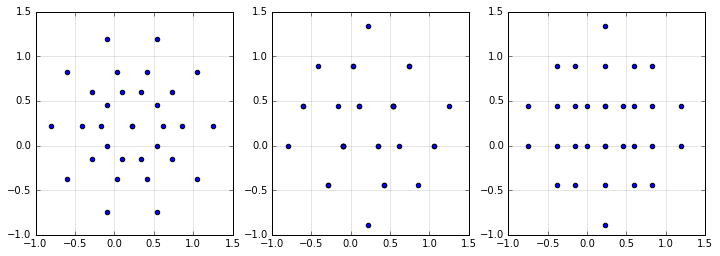

In [11]:
fig = plt.figure(figsize=(12, 4))

fig_xy = fig.add_subplot(131)
fig_xy.scatter(K[:, 0], K[:, 1])
fig_xz = fig.add_subplot(132)
fig_xz.scatter(K[:, 0], K[:, 2])
fig_yz = fig.add_subplot(133)
fig_yz.scatter(K[:, 1], K[:, 2])

fig_xy.grid(alpha=0.2, linestyle='-')
fig_xy.set_autoscale_on(False)
fig_xy.axis([-1, 1.5, -1, 1.5])
fig_xz.grid(alpha=0.2, linestyle='-')
fig_xz.set_autoscale_on(False)
fig_xz.axis([-1, 1.5, -1, 1.5])
fig_yz.grid(alpha=0.2, linestyle='-')
fig_yz.set_autoscale_on(False)
fig_yz.axis([-1, 1.5, -1, 1.5])

plt.show()

We notice that along the Z axis, the projected vertices seem to cluster along 6 levels. Indeed, according to *Seneschal 6.4.2 p196*, **all** points in `Z5^p` will project onto the middle 4 horizontal levels.

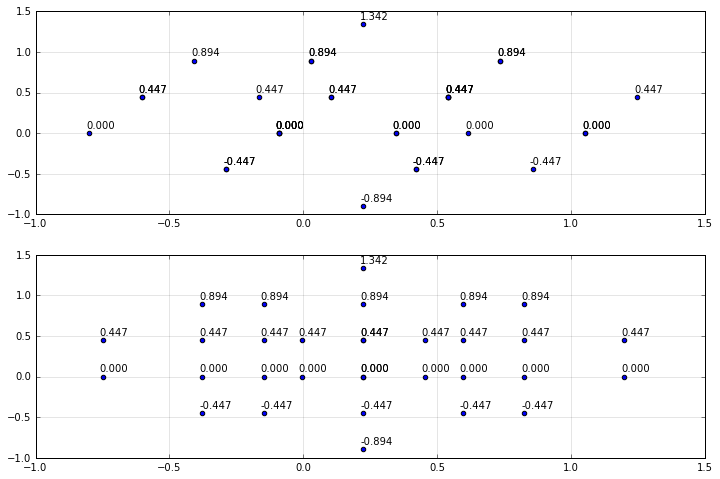

In [12]:
lvl_fig = plt.figure(figsize=(12, 8))

lvl_xz = lvl_fig.add_subplot(2, 1, 1)
lvl_xz.scatter(K_xz[:, 0], K_xz[:, 1])
lvl_xz.grid(alpha=0.2, linestyle='-')
lvl_xz.set_autoscale_on(False)
lvl_xz.axis([-1, 1.5, -1, 1.5])

lvl_yz = lvl_fig.add_subplot(2, 1, 2)
lvl_yz.scatter(K_yz[:, 0], K_yz[:, 1])
lvl_yz.grid(alpha=0.2, linestyle='-')
lvl_yz.set_autoscale_on(False)
lvl_yz.axis([-1, 1.5, -1, 1.5])

for i, e in enumerate(K_xz):
    x, y, z, a, b = V0_p.i_to_xyzab(i)
    dot = np.dot(e, np.array([0,1]))
    lvl_xz.annotate(
        #'{:d},{:d},{:d},{:d},{:d}'.format(x, y, z, a, b),
        '{:.3f}'.format(dot if np.abs(dot) > 0.001 else 0),
        xy=e[0:2], xytext=(-3, 5), textcoords='offset points')

for i, e in enumerate(K_yz):
    dot = np.dot(e, np.array([0,1]))
    lvl_yz.annotate(
        '{:.3f}'.format(dot if np.abs(dot) > 0.001 else 0),
        xy=e[0:2], xytext=(-3, 5), textcoords='offset points')

plt.show()

Let's prepare convex hulls for the 4 middle layers. We'll then be able to easily test if a point in `Z5^p` projects within K by checking for insideness against the appropriate convex hull.

In [13]:
Klvl_verts = defaultdict(list)
for v in K:
    level = np.dot(v[[1, 2]], np.array([0, 1]))  # dot it with the projected u5 in the YZ plane
    Klvl_verts[int(level * 10)].append(v[[0, 1]])  # in XY plane

print sorted(Klvl_verts.keys())
    
Klvl_hulls = {level: np.array([
        Klvl_verts[level][i] for i in ConvexHull(Klvl_verts[level]).vertices
    ], np.float64)
    for level in sorted(Klvl_verts.keys())[1:-1]  # exclude the solitary vertices at levels 0 and 5
}

[-8, -4, 0, 4, 8, 13]


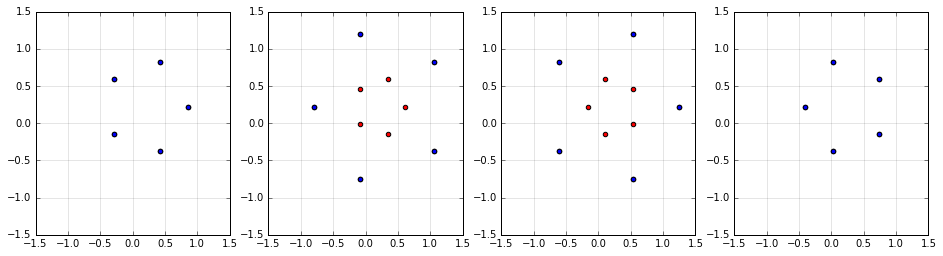

In [14]:
lvl_fig = plt.figure(figsize=(16, 4))

for i, level in enumerate(sorted(Klvl_hulls.keys())):
    hull = Klvl_hulls[level]
    hull_fig = lvl_fig.add_subplot(1, 4, i + 1)
    hull_fig.scatter([v[0] for v in Klvl_verts[level]], [v[1] for v in Klvl_verts[level]], c='r')
    hull_fig.scatter(hull[:, 0], hull[:, 1])
    hull_fig.grid(alpha=0.2, linestyle='-')
    hull_fig.set_autoscale_on(False)
    hull_fig.axis([-1.5, 1.5, -1.5, 1.5])

plt.show()

`Klvl_vecs` are arrays of 2D vectors going from one point in each hull to the next (i.e. `h_i+1 - h_i`).

`Klvl_norms` are the norms of the corresponding vectors in `Klvl_vecs`.

These values are independent of the point tested by `inside_hull` so they are computed here and saved for later.

In [15]:
Klvl_vecs = {
    # Rotate the rows of the matrix up by one, then take the difference
    level: np.vstack((Klvl_hulls[level][1:], Klvl_hulls[level][0])) - Klvl_hulls[level]
    for level in Klvl_hulls.keys()
}

Klvl_norms = {
    level: [la.norm(v) for v in Klvl_vecs[level]]
    for level in Klvl_vecs.keys()
}

In [16]:
def iterate_hull(verts, vecs, norms):
    i, n = 0, len(verts)
    while i < n:
        yield verts[i][0], verts[i][1], vecs[i][0], vecs[i][1], norms[i]
        i += 1

def inside_hull(p, poly_verts, poly_vecs, poly_norms):
    p_x, p_y = p
    
    some_det = None
    min_dist = 9001
    inside = True
    for hi_x, hi_y, vec_x, vec_y, norm in iterate_hull(poly_verts, poly_vecs, poly_norms):
        det = vec_x * (p_y - hi_y) - vec_y * (p_x - hi_x)
        #print some_det, det, ' - ', hi_x, hi_y
        abs_det = np.abs(det)
        if abs_det < 2e-10:  # can't trust the sign of the determinant
            abs_det = det = 0
        dist = abs_det / norm
        if dist < min_dist:
            min_dist = dist

        if det != 0:
            if some_det is None:
                some_det = det
            elif (some_det < 0 and det > 0) or (some_det > 0 and det < 0):
                # opposite signs
                inside = False
    
    return inside, min_dist

def inside_levels(p):
    level = int(10 * np.dot(p[[1, 2]], np.array([0, 1])))  # dot it with the projected u5 in the YZ plane
    #print level
    if level not in Klvl_hulls.keys():
        return (False, None)
    return inside_hull(p[[0, 1]], Klvl_hulls[level], Klvl_vecs[level], Klvl_norms[level])

print rebase(np.array([1, 1, -1, 0, 0]))[2:]
print inside_levels(rebase(np.array([1, 1, -1, 0, 0]))[2:])


[-0.07465125  0.97324899  0.4472136 ]
(True, 0.022776143093521536)


---
# Lattice L

In [17]:
chunk = Lattice(range(-5, 6), range(-5, 6), range(-5, 6), range(-5, 6), range(-5, 6))

L = chunk.points
L_rebased = np.matmul(Ui, L.T).T
L_proj = L_rebased[:, [0, 1]]

In [18]:
foo = chunk.xyzab_to_i(1, 0, 1, 0, 1)
print foo
print L[foo]
print L_rebased[foo]

95288
[ 1.  0.  1.  0.  1.]
[ 0.31622777 -0.22975292  0.31622777 -0.97324899  1.34164079]


---
# Penrose tiling

In [19]:
K_filter = [inside_levels(p) for p in L_rebased[:, 2:5]]

In [20]:
K_filter[15313]

(False, None)

In [21]:
data = [(
    pair[0][0],  # data[:, 0] = x
    pair[0][1],  # data[:, 1] = y
    
    pair[1][0],  # data[:, 2] = projects inside K
    pair[1][1],  # data[:, 3] = confidence
    
    i)  # data[:, 4] = index
    for i, pair in enumerate(zip(L_proj, K_filter))
    
    if pair[1][0]
]
penrose = np.array(data, np.float64)

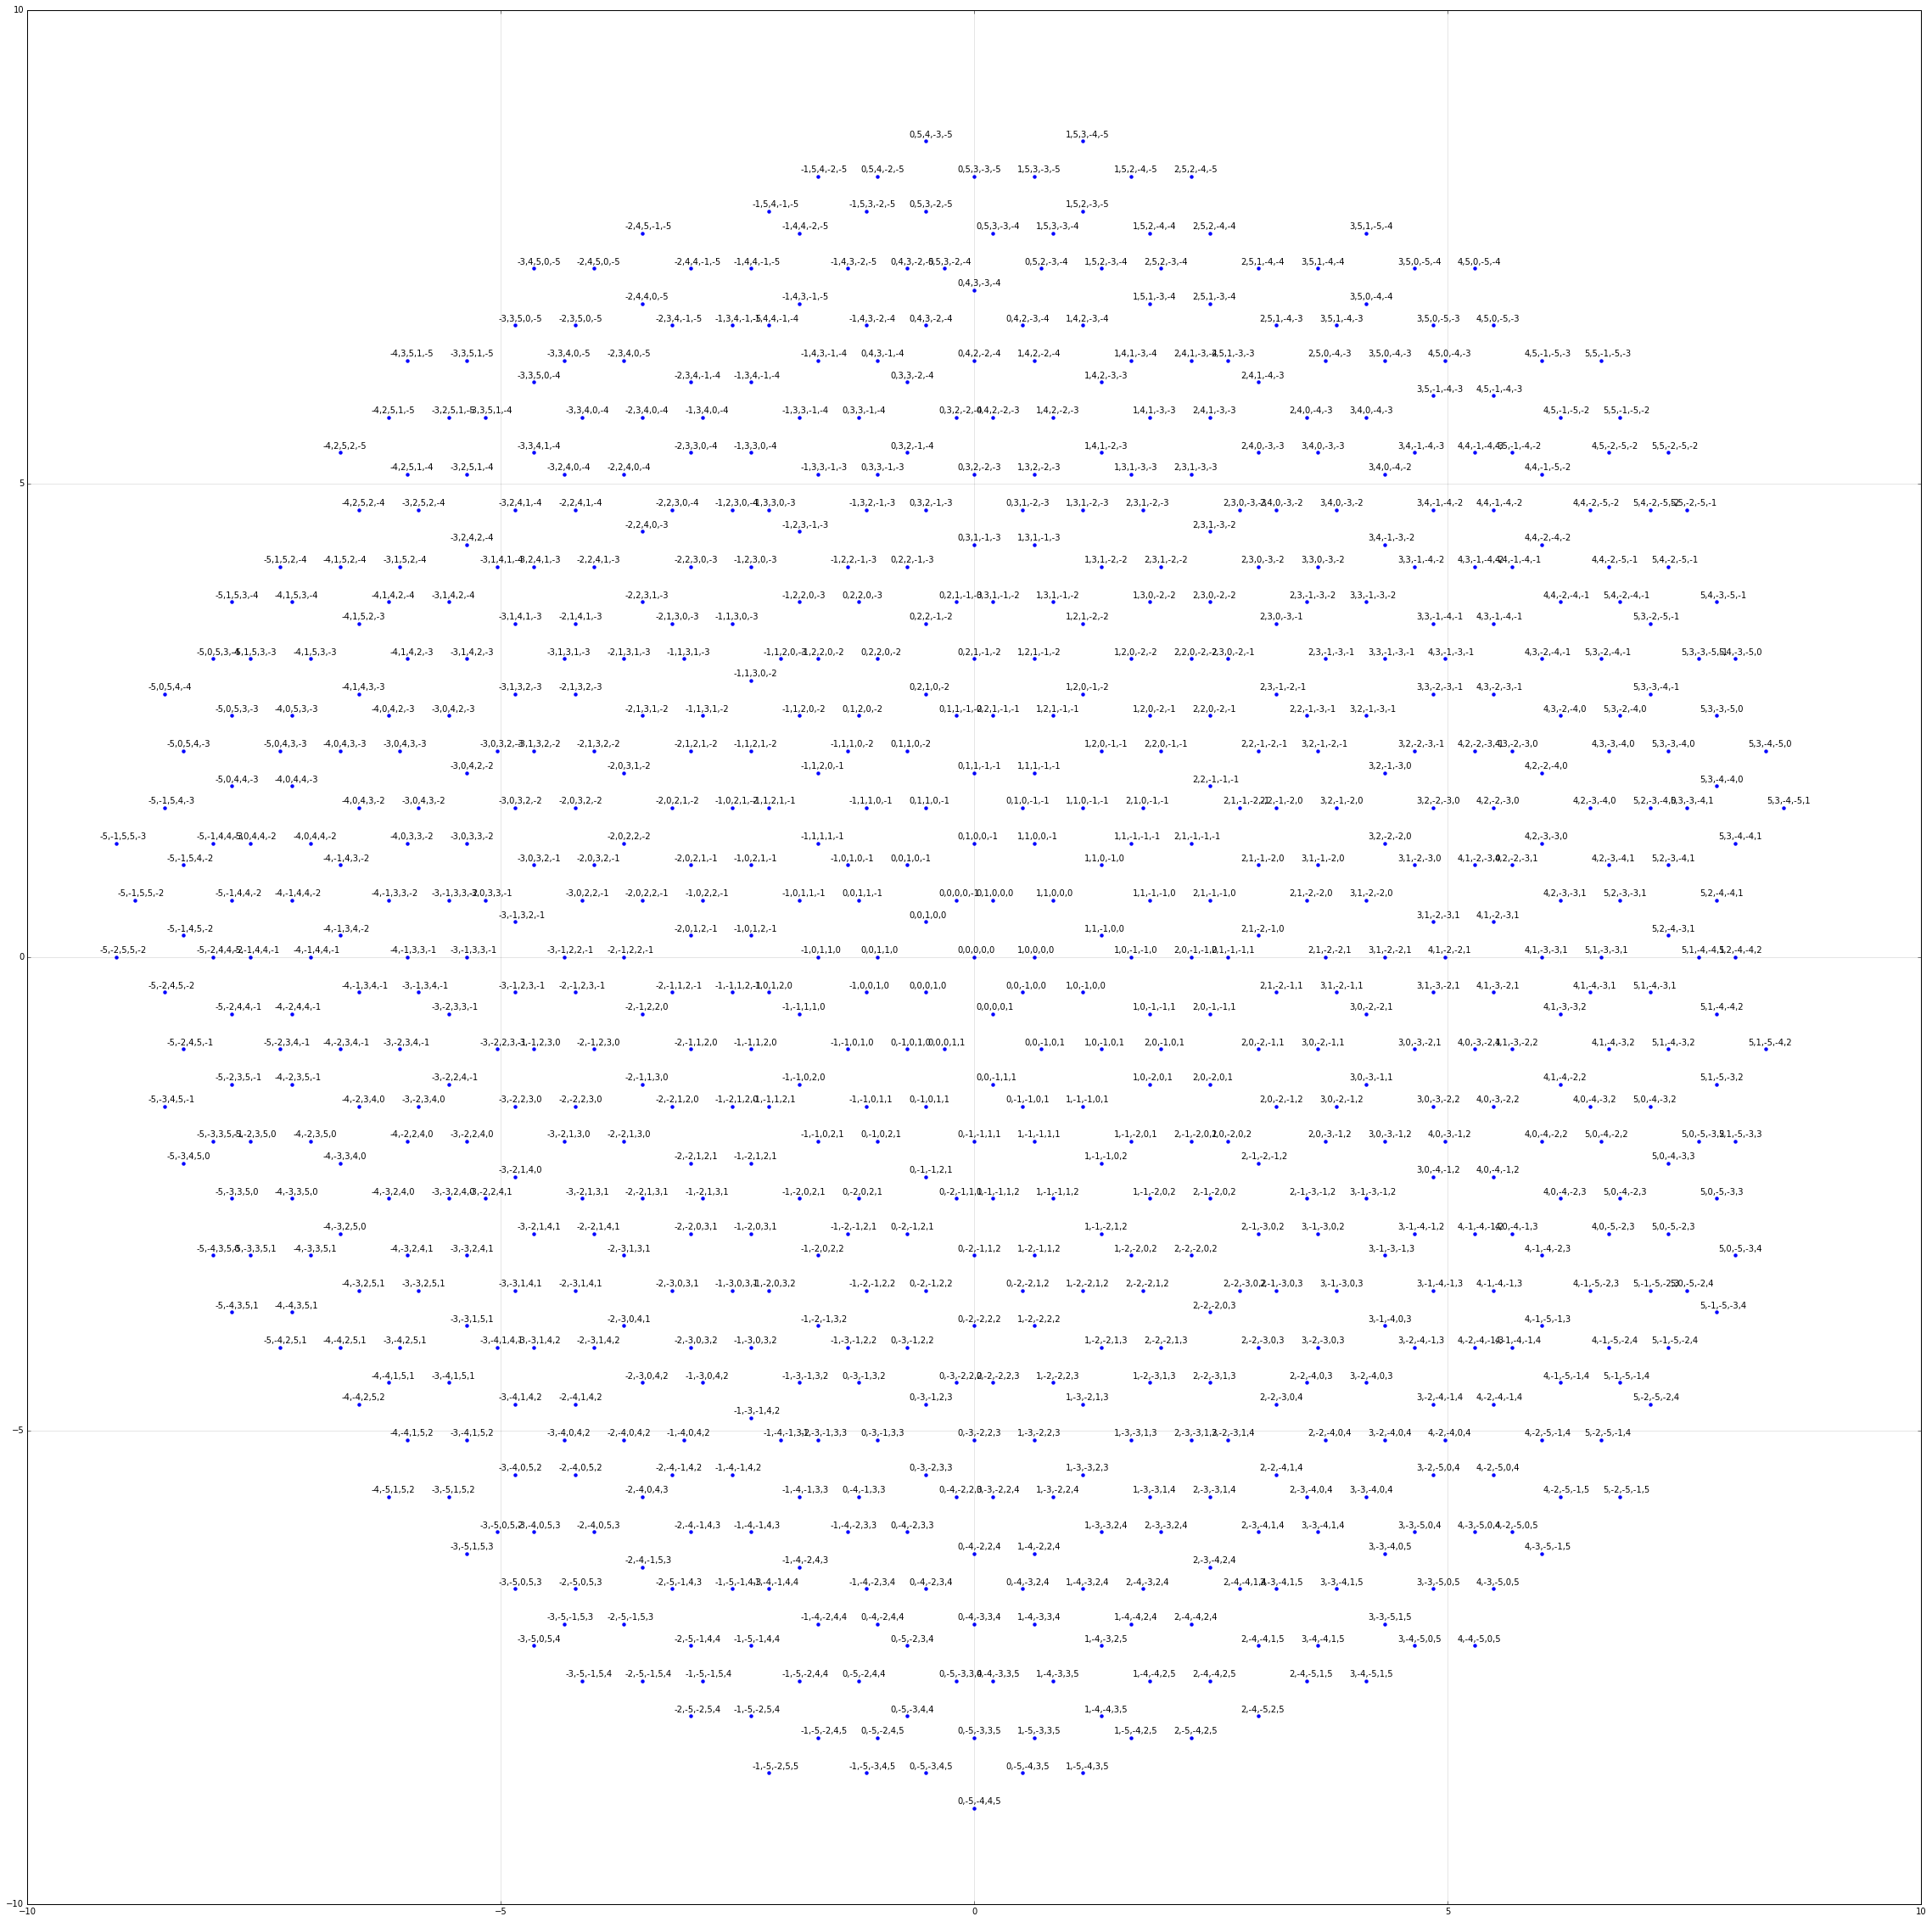

In [22]:
fig = plt.figure(figsize=(40, 40))

tiling = fig.add_subplot(111)
tiling.scatter(penrose[:,0], penrose[:,1], linewidths=0)

fived_coords = {}
for e in penrose:
    key = (int(e[0]*1000), int(e[1]*1000))
    if key not in fived_coords: fived_coords[key] = []
    fived_coords[key].append(e)
for projs in fived_coords.values():
    for j, e in enumerate(projs):
        x, y, z, a, b = chunk.i_to_xyzab(int(e[4]))
        tiling.annotate(
            '{:d},{:d},{:d},{:d},{:d}'.format(x, y, z, a, b),
            xy=e[0:2],
            xytext=(-20, 5 + j*10),
            textcoords='offset points')

#tiling.set_autoscale_on(False)
#plt.axis([-4, 4, -4, 4])
plt.grid(alpha=0.2, linestyle='-')
plt.show()

In [ ]:
V = np.array([tuple([v[0], v[1], 0]) for v in penrose], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
el = PlyElement.describe(V, 'vertex')
PlyData([el], text=True).write('penrose.ply')